<a href="https://colab.research.google.com/github/leeked/Spatial-Reasoning/blob/main/spatialReasoning_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Acknowledgements: ViT Implementation by Ross Wightman (https://github.com/rwightman/pytorch-image-models/tree/master/timm)


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import os
import pandas as pd    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from timm import create_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Helper functions
"""

# Display Image
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

**The dataset is of the following format:**

Image Directory

- Filepath to images

Data CSV

- CSV that contains the columns `Image 1 | Image 2 | Label`

In [ ]:
class cnnDataset():
    def __init__(self,input_df=None,input_dir=None,transform=None):
        # used to prepare the labels and images path
        self.input_df=input_df
        #self.input_df.columns =["image1","image2","label"]
        self.input_dir = input_dir    
        self.transform = transform

    def __getitem__(self,index):
        # getting the image path
        image1_path=os.path.join(self.input_dir,self.input_df.iat[index,0])
        image2_path=os.path.join(self.input_dir,self.input_df.iat[index,1])
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1 , torch.from_numpy(np.array([int(self.input_df.iat[index,2])],dtype=np.float32))

        """# Random Sampling (first idea for balancing set)
        same_class = random.randint(0,1)
        idx = -1
        label = -1

        # Keep looking for pair whose label matches same_class
        while label != same_class:
          idx = random.randint(0, self.input_df.shape[0] - 1)

          label = int(self.input_df.iat[idx,2])
        
        # Grab image pair
        img1_path = os.path.join(self.input_dir, self.input_df.iat[idx, 0])
        img2_path = os.path.join(self.input_dir, self.input_df.iat[idx, 1])

        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform is not None:
          img1 = self.transform(img1)
          img2 = self.transform(img2)

        return img1, img2, torch.from_numpy(np.array([int(self.input_df.iat[idx, 2])], dtype=np.float32))"""
        
    def __len__(self):
        return len(self.input_df)

In [ ]:
# Unpacking uploaded data

!rm -rf data
!rm -rf model
!unzip "/content/drive/My Drive/Research/Spatial Reasoning/CNN Resources/data.zip" -d .
#!unzip "/content/drive/My Drive/Research/Spatial Reasoning/CNN Resources/model.zip" -d .

Archive:  /content/drive/My Drive/Research/Spatial Reasoning/CNN Resources/data.zip
   creating: ./data/
  inflating: ./data/check.csv        
   creating: ./data/testing/
 extracting: ./data/testing/1.jpg    
 extracting: ./data/testing/10.jpg   
 extracting: ./data/testing/11.jpg   
 extracting: ./data/testing/2.jpg    
  inflating: ./data/testing/3.jpg    
  inflating: ./data/testing/4.jpg    
 extracting: ./data/testing/5.jpg    
  inflating: ./data/testing/6.jpg    
  inflating: ./data/testing/7.jpg    
 extracting: ./data/testing/8.jpg    
 extracting: ./data/testing/9.jpg    
  inflating: ./data/testing_csv.csv  
   creating: ./data/training/
 extracting: ./data/training/1.jpg   
  inflating: ./data/training/10.jpg  
  inflating: ./data/training/11.jpg  
 extracting: ./data/training/12.jpg  
  inflating: ./data/training/13.jpg  
 extracting: ./data/training/14.jpg  
 extracting: ./data/training/15.jpg  
  inflating: ./data/training/16.jpg  
  inflating: ./data/training/17.jpg  


In [ ]:
model_file = "/content/drive/My Drive/Research/Spatial Reasoning/CNN Resources/model/vit_model.pth"

full_train_df = pd.read_csv('/content/data/training_csv.csv')
full_train_df.columns = ["image1","image2","label"]

testing_df = pd.read_csv('/content/data/testing_csv.csv')
testing_df.columns = ["image1","image2","label"]

training_dir = '/content/data/training'
testing_dir = '/content/data/testing'

check_df = pd.read_csv('/content/data/check.csv')
check_df.columns = ["image1","image2","label"]

# Determining Train/Val split
"""train_size = int(0.8 * len(full_train_df))
val_size = len(full_train_df) - train_size"""

validation_df = full_train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.2))
training_df = pd.concat([full_train_df, validation_df]).drop_duplicates(keep=False)

class_groups = training_df.groupby('label')
neg, pos = [class_groups.get_group(x) for x in class_groups.groups]

validation_df.reset_index(drop=True, inplace=True)
pos.reset_index(drop=True, inplace=True)
neg.reset_index(drop=True, inplace=True)

# Sanity check
print(f'Num rows in Training set: {len(training_df)}\nNum rows in Validation set: {len(validation_df)}')
print(full_train_df.groupby(['label']).count())
print(training_df.groupby(['label']).count())
print(validation_df.groupby(['label']).count())

print(f'\nPositive class (1); Size of class: {len(pos)}')
print(pos.head())
print(f'\nNegative class (0); Size of class: {len(neg)}')
print(neg.head())

# Load the training dataset
"""training_dataset = cnnDataset(training_df,
                            training_dir,
                            transform=transforms.Compose([transforms.Resize((100,100)),
                                                          transforms.ToTensor()]))"""
# Load the validation dataset
validation_dataset = cnnDataset(validation_df,
                            training_dir,
                            transform=transforms.Compose([transforms.Resize((224,224)),
                                                          transforms.ToTensor()]))
# Load the testing dataset
testing_dataset = cnnDataset(testing_df,
                             testing_dir,
                             transform=transforms.Compose([transforms.Resize((224,224)),
                                                           transforms.ToTensor()]))
# Load the check set
check_dataset = cnnDataset(check_df,
                           training_dir,
                           transform=transforms.Compose([transforms.Resize((224,224)),
                                                         transforms.ToTensor()]))

Num rows in Training set: 1411
Num rows in Validation set: 352
       image1  image2
label                
0        1252    1252
1         511     511
       image1  image2
label                
0        1002    1002
1         409     409
       image1  image2
label                
0         250     250
1         102     102

Positive class (1); Size of class: 409
  image1  image2  label
0  1.jpg   2.jpg      1
1  1.jpg  10.jpg      1
2  1.jpg   3.jpg      1
3  1.jpg  16.jpg      1
4  1.jpg  23.jpg      1

Negative class (0); Size of class: 1002
  image1  image2  label
0  1.jpg   5.jpg      0
1  1.jpg   6.jpg      0
2  1.jpg   7.jpg      0
3  1.jpg   8.jpg      0
4  1.jpg  11.jpg      0


In [ ]:
# Load the training, validation, and testing datasets
"""train_dataloader = DataLoader(training_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=16)"""

val_dataloader = DataLoader(validation_dataset,
                            shuffle=True,
                            num_workers=2,
                            batch_size=16)

test_dataloader = DataLoader(testing_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=16)

check_dataloader = DataLoader(check_dataset,
                              shuffle=True,
                              num_workers=2,
                              batch_size=1)

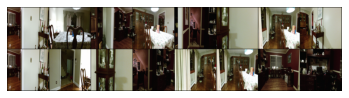

[1. 1. 0. 1. 0. 0. 0. 0.]


In [ ]:
# Create a dataloader just for simple visualization
vis_dataloader = DataLoader(validation_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that the pair is of the positive class (spatially adjacent). 0 means negative.
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
# Network using ViT for feature extraction
class ViTNetwork(nn.Module):

    def __init__(self):
        super(ViTNetwork, self).__init__()

        # vit_base_patch16_224
        model_name = 'vit_base_patch16_224'
        self.encoder = create_model(model_name, pretrained=True)
        
        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(1536, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(inplace=True),
            
            nn.Linear(384, 96),
            nn.BatchNorm1d(96),
            nn.ReLU(inplace=True),

            nn.Linear(96, 1),
            nn.Sigmoid()
        )

        self.flatten = nn.Flatten()

    def forward(self, input1, input2):
        cls_token1 = self.encoder.cls_token
        cls_token2 = self.encoder.cls_token
        for i in range(input1.shape[0] - 1):
          cls_token1 = torch.cat((cls_token1, self.encoder.cls_token))
          cls_token2 = torch.cat((cls_token2, self.encoder.cls_token))

        # First Image
        patch1 = self.encoder.patch_embed(input1)
        #print(f'Patch shape: {patch1.shape}\nCLS shape: {cls_token1.shape}')
        transformer_input1 = torch.cat((cls_token1, patch1), dim=1) + self.encoder.pos_embed

        encode1 = transformer_input1.clone()
        for i, blk in enumerate(self.encoder.blocks):
          encode1 = blk(encode1)

        encode1 = self.encoder.norm(encode1)
        transformer_output1 = encode1[:,0]
        #print(f'Output1 shape: {transformer_output1.shape}')

        # Second Image
        patch2 = self.encoder.patch_embed(input2)
        transformer_input2 = torch.cat((cls_token2, patch2), dim=1) + self.encoder.pos_embed

        encode2 = transformer_input2.clone()
        for i, blk in enumerate(self.encoder.blocks):
          encode2 = blk(encode2)

        encode2 = self.encoder.norm(encode2)
        transformer_output2 = encode2[:,0]
        #print(f'Output2 shape: {transformer_output2.shape}')

        
        # Concatenate the image pair
        output = torch.cat((transformer_output1, transformer_output2), dim=1)
        #print(f'Output cat shape: {output.shape}\n\n')
        
        output = self.fc1(output)

        return output

In [ ]:
"""
Using BCE Loss for binary classification.
Using Adam optimizer with learning rate  = 5e-4
                          regularization = 1e-5
"""

model = ViTNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 1e-5)

In [ ]:
"""
Main Training Body
"""

train_loss = []
train_acc = []
val_acc = [] 
val_loss = []
num_epochs = 30

# Determine best model
last_best = np.inf
best_so_far = None

# Cycle through all negative pairs
start_ind = 0
end_ind = len(pos)

# Iterate throught the epochs
for epoch in range(num_epochs):
  running_val_loss    = 0
  running_train_loss  = 0
  running_train_acc, running_val_acc = 0, 0

  # Selecting negative chunk
  idx = np.arange(start_ind, end_ind, 1)%len(neg)

  curr_train_set = pd.concat([pos, neg.iloc[idx]])

  training_dataset = cnnDataset(curr_train_set, 
                                training_dir,
                                transform=transforms.Compose([transforms.Resize((224,224)),
                                                              transforms.ToTensor()]))
  train_dataloader = DataLoader(training_dataset,
                                shuffle=True,
                                num_workers=2,
                                batch_size=16)

  # Training Loop
  for i, (img0, img1, label) in enumerate(train_dataloader, 0):
    model.train()

    # Send the images and labels to CUDA
    img0, img1, label = img0.to(device), img1.to(device), label.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Pass in the two images into the network and obtain outputs
    output = model(img0, img1)

    # Calculate loss
    loss_bce = criterion(output, label)

    # Calculate the backpropagation
    loss_bce.backward()

    # Optimize
    optimizer.step()

    # Collect training accuracy
    running_train_acc += torch.sum(torch.eq(output, label)).div(label.size(dim=0)).item()

    # Collect training loss
    running_train_loss += loss_bce.item()

  # Validation Loop
  with torch.no_grad():
    model.eval()

    for i, (v_img0, v_img1, v_label) in enumerate(val_dataloader, 0):

      v_img0, v_img1, v_label = v_img0.to(device), v_img1.to(device), v_label.to(device)

      v_output = model(v_img0, v_img1)

      v_loss = criterion(v_output, v_label)

      running_val_loss += v_loss.item()

      running_val_acc += torch.sum(torch.eq(v_output, v_label)).div(v_label.size(dim=0)).item()

  # Determine the average of the loss over the number of batches
  train_loss_avg  = running_train_loss / len(train_dataloader)
  val_loss_avg    = running_val_loss / len(val_dataloader)

  # Avg Acc
  train_acc_avg = running_train_acc / len(train_dataloader)
  val_acc_avg = running_val_acc / len(val_dataloader)

  print(f"Epoch number {epoch}\n Training loss {train_loss_avg} Validation loss {val_loss_avg}\n Training Acc {train_acc_avg} Validation Acc {val_acc_avg}")

  # Save best val_loss model so far
  if val_loss_avg < last_best:
    print("Saving new best model...\n")
    best_so_far = model.state_dict()
    
    last_best = val_loss_avg

  train_loss.append(train_loss_avg)
  val_loss.append(val_loss_avg)

  train_acc.append(train_acc_avg)
  val_acc.append(val_acc_avg)

  start_ind += len(pos)
  end_ind += len(pos)

Epoch number 0
 Training loss 0.4877040758728981 Validation loss 0.9770445031198588
 Training Acc 0.0 Validation Acc 0.0
Saving new best model...

Epoch number 1
 Training loss 0.5935978218913078 Validation loss 5.595666321841153
 Training Acc 0.0 Validation Acc 0.0
Epoch number 2
 Training loss 0.592578031695806 Validation loss 0.6202599013393576
 Training Acc 0.0 Validation Acc 0.0
Saving new best model...



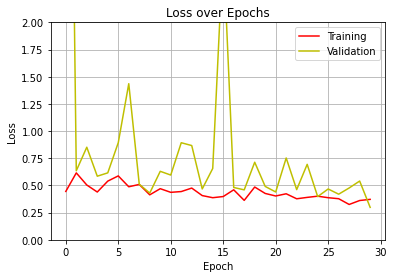


Percent Positive Class: 0.49803685897435895



In [ ]:
"""
Visualization of loss over epochs
"""

plt.plot(range(num_epochs), train_loss, c='r')
plt.plot(range(num_epochs), val_loss, c='y')
plt.legend(['Training','Validation'])
plt.grid(True)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2)
percent_positive = np.mean(np.array(percent_positive))
plt.show()

print(f"\nPercent Positive Class: {percent_positive}\n")
print(f"Average Training Accuracy: {np.mean(train_acc)}\n")
print(f"Average Validation Accuracy: {np.mean(val_acc)}\n")

In [ ]:
print(model)

In [ ]:
# Save model
torch.save(best_so_far, '/content/drive/My Drive/Research/Spatial Reasoning/CNN Resources/model/model_properbalanced.pth')

In [ ]:
# Test model
model.load_state_dict(torch.load(model_file))
model.eval()
acc = []
test_loss = []

with torch.no_grad():
  
  for i, (img0, img1, label) in enumerate(test_dataloader, 0):
    img0, img1, label = img0.to(device), img1.to(device), label.to(device)

    output = model(img0, img1)

    loss = criterion(output, label)
    test_loss.append(loss.item())

    batch_acc = torch.sum(torch.eq(output, label)).div(label.size(dim=0)).item()

    acc.append(batch_acc.item())

acc = np.array(acc)
test_loss = np.array(test_loss)
print(f"Average Test Accuracy across batches: {np.mean(acc)}\nAverage Test Loss across batches: {np.mean(test_loss)}")

Average Test Accuracy across batches: 0.536391019821167
Average Test Loss across batches: 0.6689215451478958


## Test Result Visualization and Check Results

In [ ]:
model.load_state_dict(torch.load(model_file))

test_vis_loader = DataLoader(testing_dataset,
                             shuffle=True,
                             num_workers=2,
                             batch_size=1)

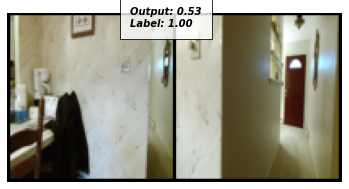

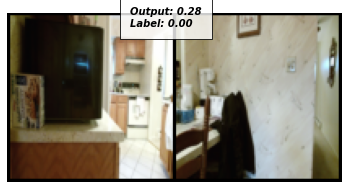

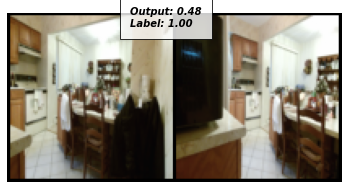

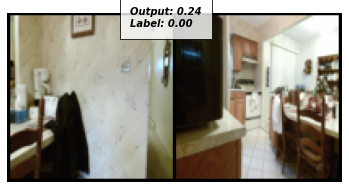

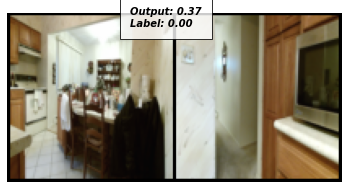

In [ ]:
test_data_iter = iter(test_vis_loader)

with torch.no_grad():
  model.eval()
  for i in range(5):
    img1, img2, label = next(test_data_iter)
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)

    img_pair = torch.cat((img1, img2), 0)

    output = model(img1, img2)

    imshow(torchvision.utils.make_grid(img_pair.detach().cpu()), f'Output: {output.item():.2f}\nLabel: {label.item():.2f}')

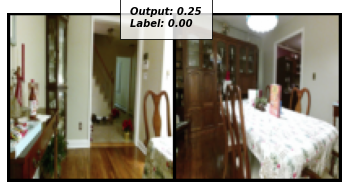

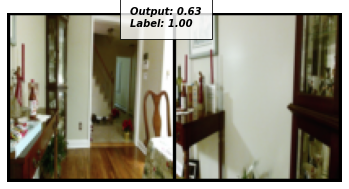

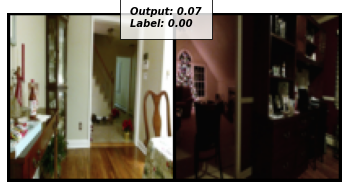

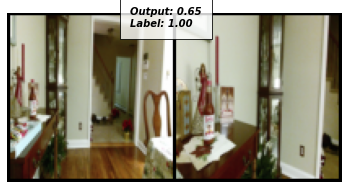

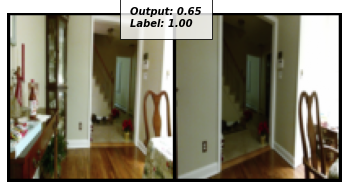

In [ ]:
check_data_iter = iter(check_dataloader)

with torch.no_grad():
  model.eval()
  for i in range(5):
    img1, img2, label = next(check_data_iter)
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)


    img_pair = torch.cat((img1, img2), 0)

    output = model(img1, img2)

    imshow(torchvision.utils.make_grid(img_pair.detach().cpu()), f'Output: {output.item():.2f}\nLabel: {label.item():.2f}')